# Creating a large network of AdEx neurons connected with synapses

In this notebook we first investigate parameter space of the AdEx neuron models, then select candidates for future pyramidal and interneuron parameter sets.

Next we create a network consisting of PCs and interneurons, which we connect by synapses with plasticity mechanisms. 

In [ ]:
# check if notebook is running in Colab and install packages if it is
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
  ! pip install brian2
  ! pip install pandas
  ! wget https://raw.githubusercontent.com/abrazhe/nbpc-masters-ru/master/notebooks/input_factory.py
  ! wget https://raw.githubusercontent.com/abrazhe/nbpc-masters-ru/master/notebooks/adex_params.csv

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#style.use(('ggplot','seaborn-muted'))
# Крупные шрифты в рисунках
rc('xtick', labelsize=16) 
rc('ytick', labelsize=16)
rc('axes',labelsize=16, grid=True)
rc('font',size=16)

In [3]:
import pandas as pd

In [4]:
from brian2 import *

In [5]:
prefs.codegen.target = 'numpy'  # use the Python fallback

In [6]:
import input_factory as inpf

In [7]:
def beautify_spikes(statemon,spikemon,neuron_id):
    "helper function to make voltage trajectories of IF neurons to appear with spikes"
    vm = statemon[neuron_id].v[:]
    offset = statemon.t[0]#/defaultclock.dt
    spike_times = spikemon.t[spikemon.i == neuron_id]
    for t in spike_times:
        i = int((t-offset) / defaultclock.dt)
        vm[i] = 20*mV
    return vm

In [8]:
def convert_table_cell(col_name):
    units = col_name.split(' ')[1][1:-1]

def convert_from_table(row):
    return dict(
        a = float(row['a [nS]'])*nS,
        b = float(row['b [pA]'])*pA,
        tau_w = float(row['tau_u [ms]'])*ms,
        tau_m = float(row['tau_m [ms]'])*ms,
        Vreset = float(row['Vreset [mV]'])*mV,
        C = float(row['tau_m [ms]'])*ms*gl,
        Ibias = 0*pA
    )

In [9]:
def sample_from_class(parameters,sigma=0.01):
    if iterable(parameters['a']):
        N = len(parameters['a'])
        k = randint(N)
        params = {key:parameters[key][k] for key in ['a','b','tau_m','tau_w', 'Vreset','Ibias']}
    else:
        params = parameters
    multipliers = 1 + sigma*randn(10)
    return dict(a = params['a']*multipliers[0],
                b = params['b']*multipliers[1],
                tau_m = params['tau_m']*multipliers[2],
                tau_w = params['tau_w']*multipliers[3],
                Vreset = params['Vreset']*multipliers[4],
                Ibias = params['Ibias']*multipliers[5]
               )


In [10]:
def update_neuron_parameters(neurons, k, pars):
    neurons.a[k] = pars['a']
    neurons.b[k] = pars['b']
    neurons.tau_m[k] = pars['tau_m']
    neurons.tau_w[k] = pars['tau_w']
    neurons.Vreset[k] = pars['Vreset']
    neurons.Ibias[k] = pars['Ibias']

In [11]:
def raster_spikes(spikemon,Nexc=None,ax=None,colors='rb'):
    if ax is None:
        f,ax = subplots(1,1)
    if Nexc is None:
        Nexc = max(spikemon.i)
    exc_spikes = spikemon.i<Nexc
    if any(exc_spikes):
        ax.plot(spikemon.t[exc_spikes]/ms, spikemon.i[exc_spikes],',',c=colors[0])
    if any(~exc_spikes):
        ax.plot(spikemon.t[~exc_spikes]/ms, spikemon.i[~exc_spikes],',',c=colors[1])

## AdEx neuron

In [12]:
## Parameters that are shared by all neurons

# Neurons
Vth = -50*mV   # rheobase threshold
El = -70*mV     # resting membrane potential
Vcut = -20*mV    # spike detection threshold
deltaT = 2*mV  # spike initiation sharpness
Rin = 500*Mohm  # input resistance of a neuron at rest
gl = 1/Rin



# Synapses
E_e = 0*mV     # Excitatory synaptic reversal potential (AMPA and NMDA receptors)
E_i = -80*mV   # Inhibitory synaptic reversal potential (GABAA receptors)
tau_e = 5*ms   # time scale of excitatory synaptic conductance
tau_i = 10*ms  # time scale of excitatory synaptic conductance



AdEx_equations = Equations('''
dv/dt = (-(v-El) + deltaT*exp((v-Vth)/deltaT) + Rin*(Isyn + Ibias + Iapp - w))/tau_m : volt 
dw/dt = (a*(v-El) - w)/tau_w: amp  # adaptation variable
a : siemens
b : amp
tau_m : second
tau_w : second
Vreset: volt
stim_amp : 1
Ibias : amp
Iapp = stim_amp*input_current(t,i): amp
''')

# Synaptic input
synaptic_equations = Equations("""
Isyn =  - g_e*(v-E_e) - g_i*(v-E_i) : amp
dg_e/dt = -g_e/tau_e : siemens
dg_i/dt = -g_i/tau_i : siemens
""")

In [13]:
adex_params = pd.read_csv('adex_params.csv',index_col='type')
adex_params

,tau_m [ms],a [nS],tau_u [ms],b [pA],Vreset [mV]
type,,,,,
tonic,20.0,0.0,30,60,-55
adapting,200.0,0.0,100,5,-55
init. burst,5.0,0.5,100,7,-51
bursting,5.0,-0.5,100,7,-46
irregular,9.9,-0.5,100,7,-46
transient,10.0,1.0,100,10,-60
delayed,5.0,-1.0,100,10,-60


In [14]:
tonic_pars = convert_from_table(adex_params.loc['tonic'])
adapting_pars = convert_from_table(adex_params.loc['adapting'])
bursting_pars = convert_from_table(adex_params.loc['bursting'])
initial_burst_pars = convert_from_table(adex_params.loc['init. burst'])
irregular_pars = convert_from_table(adex_params.loc['irregular'])
transient_pars = convert_from_table(adex_params.loc['transient'])
delayed_pars = convert_from_table(adex_params.loc['delayed'])

In [15]:
tonic_pars

{'a': 0. * siemens,
 'b': 60. * pamp,
 'tau_w': 30. * msecond,
 'tau_m': 20. * msecond,
 'Vreset': -55. * mvolt,
 'C': 40. * pfarad,
 'Ibias': 0. * amp}

In [16]:
transient_pars

{'a': 1. * nsiemens,
 'b': 10. * pamp,
 'tau_w': 100. * msecond,
 'tau_m': 10. * msecond,
 'Vreset': -60. * mvolt,
 'C': 20. * pfarad,
 'Ibias': 0. * amp}

In [17]:
sample_from_class(transient_pars)

{'a': 0.98640979 * nsiemens,
 'b': 10.10597307 * pamp,
 'tau_m': 9.81448136 * msecond,
 'tau_w': 99.74972464 * msecond,
 'Vreset': -60.00831067 * mvolt,
 'Ibias': 0. * amp}

Here we create a source of "natural" drive to our future network in form of Poisson spike trains from 100 neurons

In [18]:
#set_device('cpp_standalone')

In [19]:
start_scope()
P = PoissonGroup(25,  'rand()*25*Hz')
Sp = SpikeMonitor(P)

In [20]:
run(5*second)

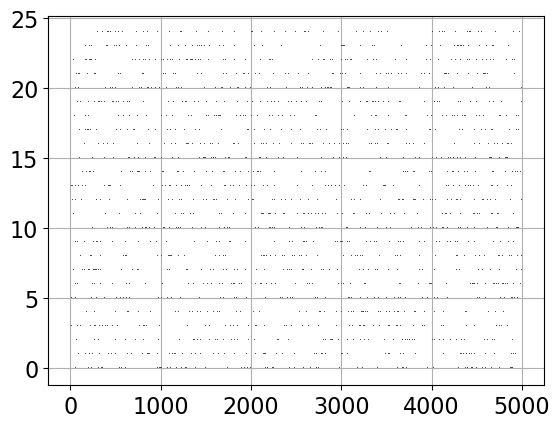

In [21]:
raster_spikes(Sp,100,colors='gg')

## Now create a new network with 80% pyramidal cells and 20% interneurons

Below we will create a model network with many principal (excitatory) neurons and a smaller amount of interneurons (inhibitory). A random subset of principal neurons will receive "sensory" input in form of Poisson spike trains.

Neurons within the network will be connected with synapses having both short-time plasticity (Tsodyks & Markram model) and spike-timing dependent plasticity (STDP).

In [22]:
seed(4022)

In [23]:
start_scope()


Ninh = 500
Nexc = 4*Ninh


Nneurons = Nexc + Ninh

defaultclock.dt = 0.1*ms

G = NeuronGroup(Nneurons, AdEx_equations+synaptic_equations,threshold='v>Vcut', 
                reset='v=Vreset; w += b',
                method='exponential_euler')

G.set_states(dict(v=El,w=0))

M = StateMonitor(G, ['v','g_e'], record=True,)
S = SpikeMonitor(G,)

In [24]:
for k in range(Nneurons):
    #exemplar_parameters = pyramidal_pars if k < Nexc else interneuron_pars
    #exemplar_parameters = pyramidal_pars# if k < Nexc else interneuron_pars
    exemplar_parameters = adapting_pars if k < Nexc else tonic_pars
    sigma = 0.05 if k < Nexc else 0.01
    p = sample_from_class(exemplar_parameters,sigma)
    #update_neuron_parameters(G,k,adapting_pars)
    update_neuron_parameters(G,k,p)

In [25]:
P = PoissonGroup(25,  'rand()*20*Hz')
Sp = SpikeMonitor(P)

### Setting up synaptic connections

In [27]:
tau_ps = 0.8*second   # facilitation timescale (seconds, really?)
tau_ns = 1.5*second   # replenishing timescale
tau_stdp = 20*ms     # STDP time constant

p_s0 = 0.6            # ground-state probability of release
epsilon = 0.05        # sparsity synaptic connectivity

Apre0 = 0.01
Apost0 = -Apre0*1.05

w_e = 20*0.05*nS
w_i = 20*1*nS
pool_size=10

stdp_value = 0.05 # change between 0 and 1

tm_plasticity_model = Equations('''
dp_s/dt = (p_s0-p_s)/tau_ps : 1 (event-driven)    # release probability
dn_s/dt = (1-n_s)/tau_ns   : 1    (event-driven)    # fraction of resources available
''')

stdp_model=Equations('''
dApre/dt = -Apre/tau_stdp : 1 (event-driven)    # STDP
dApost/dt = -Apost/tau_stdp : 1(event-driven)   # STDP
w_syn: 1
''')

plasticity_action_pre='''
p_s += p_s0*(1-p_s) # facilitation
r_s = p_s*n_s       # probability of release
n_s -= r_s          # depletion
'''

plasticity_action_pre_s='''
p_s += p_s0*(1-p_s) # facilitation
r_s = p_s*n_s       # probability of release
will_release = (rand() < r_s)
n_s = clip(n_s-will_release/pool_size,0,1)          # depletion
'''

stdp_action_pre='''
Apre += Apre0
'''

stdp_action_post='''
Apost += Apost0
'''


pre_actions_e = '''
w_syn = clip(w_syn+Apost, (1-stdp_value)*w_e/nS, w_e/nS) 
g_e_post += w_syn*r_s*nS
'''

pre_actions_e_s = '''
w_syn = clip(w_syn+Apost, (1-stdp_value)*w_e/nS, w_e/nS) 
g_e_post += w_syn*will_release*nS
'''


pre_actions_i = '''
w_syn = clip(w_syn+Apost, (1-stdp_value)*w_i/nS, w_i/nS) 
g_i_post += w_syn*r_s*nS
'''

pre_actions_i_s = '''
w_syn = clip(w_syn+Apost, (1-stdp_value)*w_i/nS, w_i/nS) 
g_i_post += w_syn*will_release*nS
'''


post_actions_e='''
w_syn = clip(w_syn+Apre,(1-stdp_value)*w_e/nS,w_e/nS)
'''

post_actions_i='''
w_syn = clip(w_syn+Apre,(1-stdp_value)*w_i/nS,w_i/nS)
'''

In [28]:
S_exc = Synapses(G[:Nexc],G, model=tm_plasticity_model+stdp_model,
                 on_pre=plasticity_action_pre+stdp_action_pre+pre_actions_e,
                 on_post=stdp_action_post+post_actions_e)

                
S_inh = Synapses(G[Nexc:],G, model=tm_plasticity_model+stdp_model,
                 on_pre=plasticity_action_pre+stdp_action_pre+pre_actions_i,
                 on_post=stdp_action_post+post_actions_i)


S_input = Synapses(P,G[:Nexc],model=tm_plasticity_model,
                 on_pre=plasticity_action_pre+'g_e_post += 10*w_e*r_s')

In [29]:
%%time 

S_input.connect(p=0.01)

S_exc.connect(p=epsilon)
S_exc.delay = '10*ms + 0.1*randn()*ms'

S_inh.connect(p=2*epsilon)
S_inh.delay = '10*ms + 0.1*randn()*ms'

CPU times: user 205 ms, sys: 8.94 ms, total: 214 ms
Wall time: 214 ms


In [30]:
S_input.active=True
S_exc.active=False
S_inh.active=False

In [31]:
net = Network(G,P,M,S,Sp,S_exc,S_inh,S_input)

In [32]:
for s in [S_input, S_exc, S_inh]:
    #s.delay = "average_delay-0.5*delay_jitter + delay_jitter*rand()"  # delays in synapses.
    s.p_s = p_s0
    s.n_s = 1.0

In [33]:
net.store()

In [34]:
input_current = inpf.get_step_current(1000, 6000, 1*ms, 1.0*pA,Nneurons=Nneurons)

### No spike input to network

In [35]:
net.restore()
S_input.active=False
S_exc.active=False
S_inh.active=False
G.stim_amp[:Nexc//2] = 35

In [36]:
%time net.run(10*second,report='text')

Starting simulation at t=0. s for a duration of 10. s
5.0949 s (50%) simulated in 10s, estimated 10s remaining.
10. s (100%) simulated in 19s
CPU times: user 16 s, sys: 3.55 s, total: 19.6 s
Wall time: 19.6 s


(0.0, 9999.9)

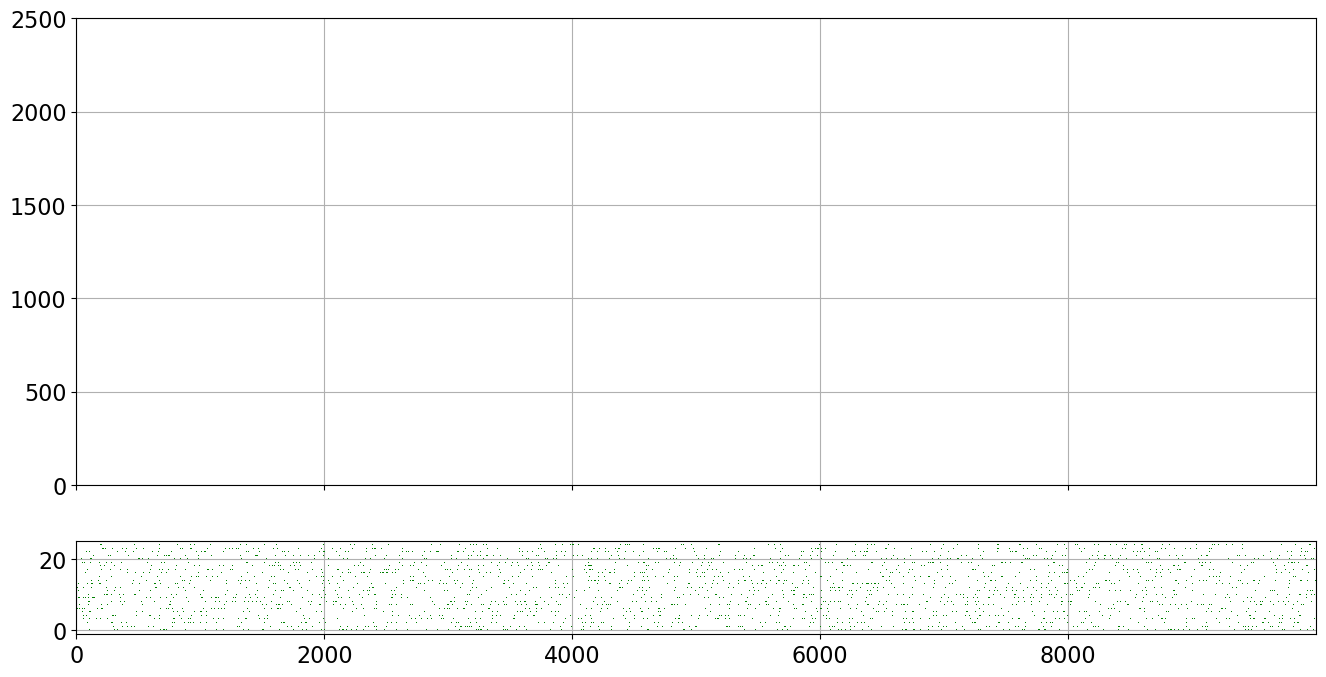

In [37]:
f,axs = subplots(2,1,sharex=True,figsize=(16,8),gridspec_kw=dict(height_ratios=(5,1)))
raster_spikes(S,Nexc,axs[0])
axs[0].set_ylim(0,Nneurons)
raster_spikes(Sp,100,axs[1],colors='gg')
xlim(M.t[0]/ms,M.t[-1]/ms)

### Turn on Poisson input

In [38]:
net.restore()
S_input.active=True
S_exc.active=False
S_inh.active=False
G.stim_amp[:Nexc//2] = 35

In [39]:
%time net.run(10*second,report='text')

Starting simulation at t=0. s for a duration of 10. s
6.4378 s (64%) simulated in 10s, estimated 6s remaining.
10. s (100%) simulated in 15s
CPU times: user 15.8 s, sys: 9.81 ms, total: 15.8 s
Wall time: 15.8 s


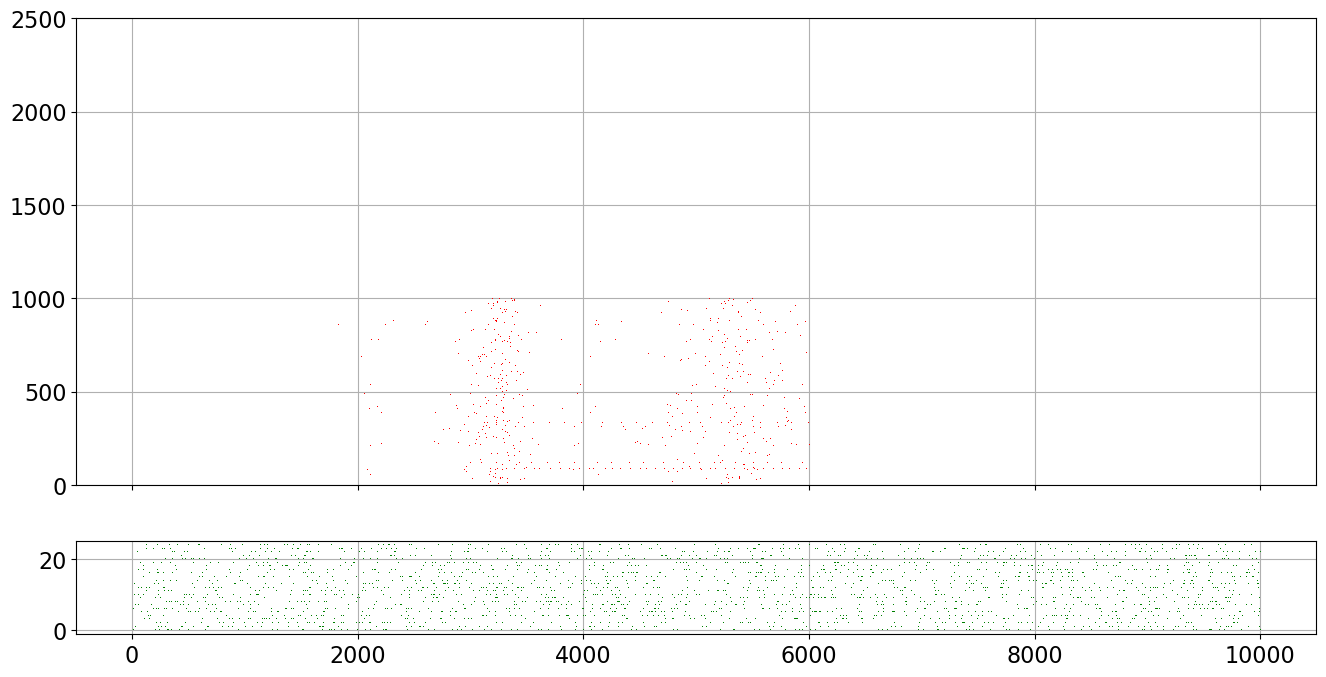

In [40]:
f,axs = subplots(2,1,sharex=True,figsize=(16,8),gridspec_kw=dict(height_ratios=(5,1)))
raster_spikes(S,Nexc,axs[0])
axs[0].set_ylim(0,Nneurons)
raster_spikes(Sp,100,axs[1],colors='gg')
#xlim(M.t[0]/ms,M.t[-1]/ms)
#xlim(500, 8000)

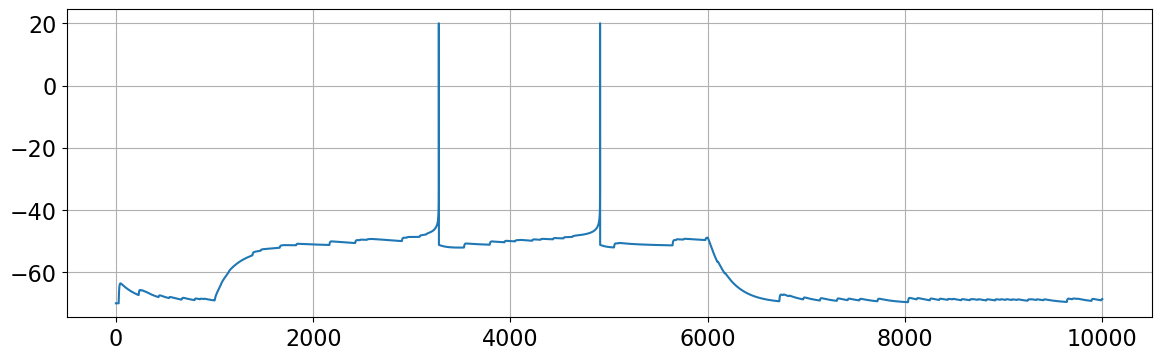

In [41]:
k = 450
figure(figsize=(14,4))
plot(M.t/ms, beautify_spikes(M,S,k)/mV)

Text(0, 0.5, 'g_e, nS')

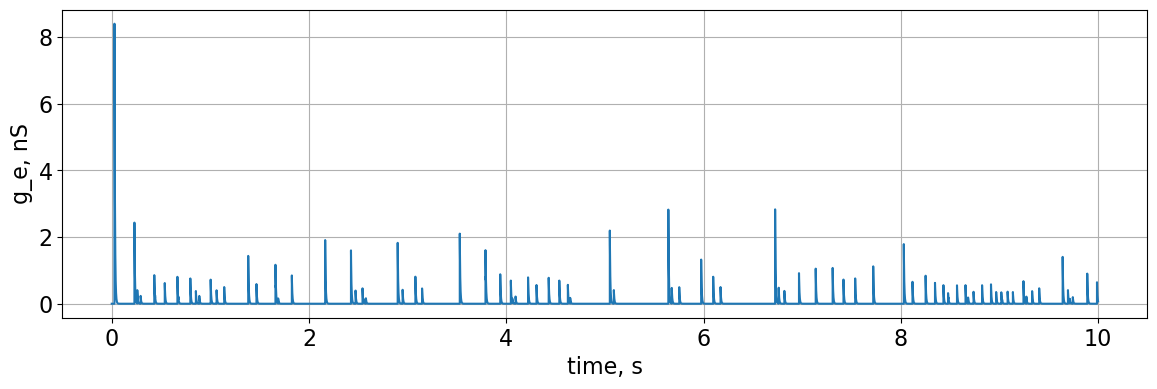

In [42]:
#k = randint(Nexc)
figure(figsize=(14,4))
plot(M.t/second, M.g_e[k]/nS)
xlabel('time, s'); ylabel('g_e, nS')

### Add excitatory synapses

In [43]:
net.restore()
stdp_value = 0.1 # change between 0 and 1

In [44]:
S_input.active=True
S_exc.active=True
S_inh.active=False
G.stim_amp[:Nexc//2] = 35

In [45]:
%time net.run(10*second,report='text')

Starting simulation at t=0. s for a duration of 10. s
5.6281 s (56%) simulated in 10s, estimated 8s remaining.
10. s (100%) simulated in 17s
CPU times: user 18 s, sys: 430 μs, total: 18 s
Wall time: 18 s


Text(0, 0.5, '# Poisson generator')

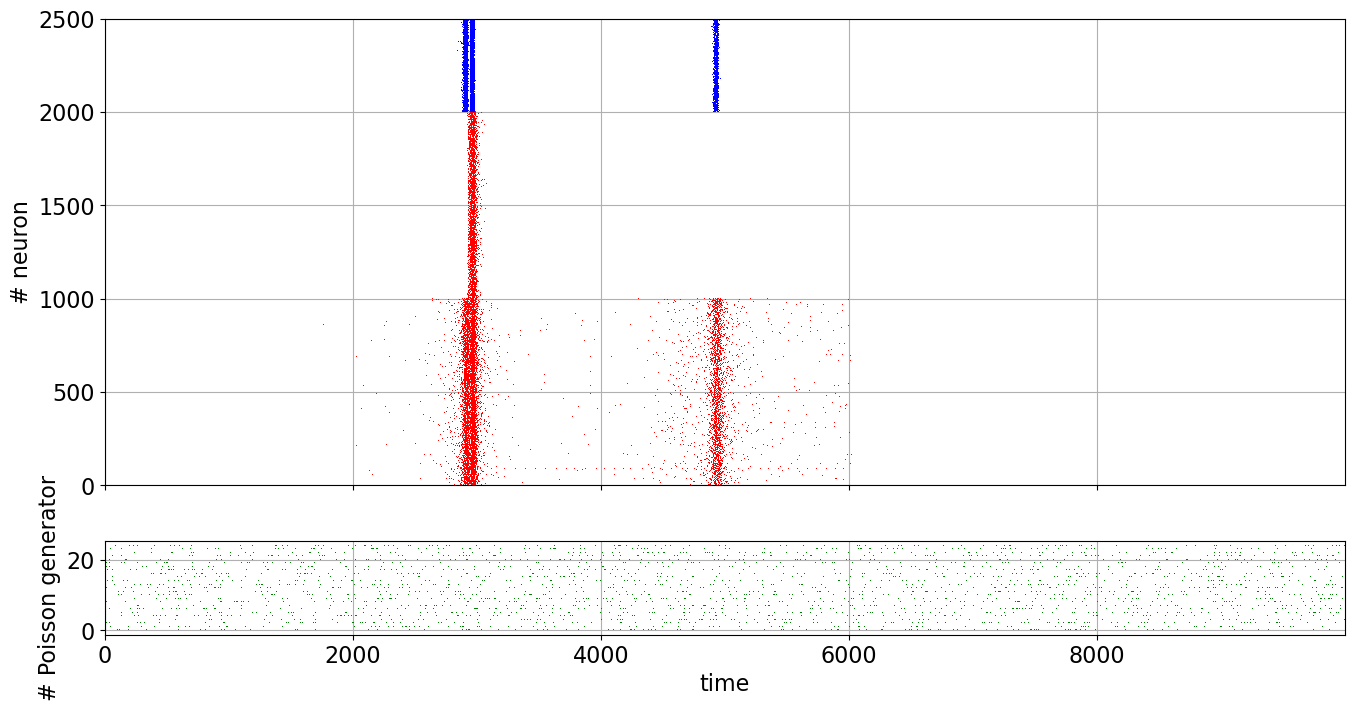

In [46]:
f,axs = subplots(2,1,sharex=True,figsize=(16,8),gridspec_kw=dict(height_ratios=(5,1)))

raster_spikes(S,Nexc,axs[0])
raster_spikes(Sp,100,axs[1],colors='gg')

axs[0].set_ylim(0,Nneurons)

xlim(M.t[0]/ms,M.t[-1]/ms)
axs[0].set_ylabel('# neuron')
xlabel('time')
ylabel('# Poisson generator')

450


Text(0, 0.5, 'Vm, mV')

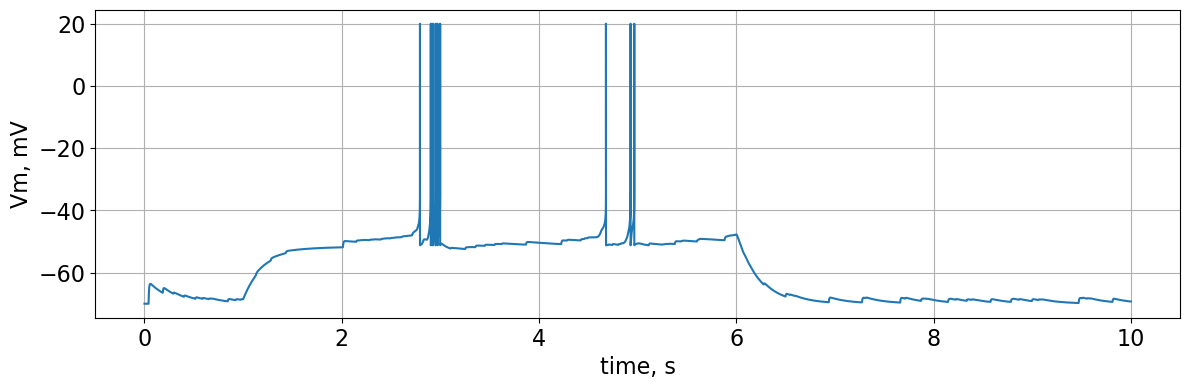

In [47]:
print(k)
figure(figsize=(14,4))

plot(M.t/second, beautify_spikes(M,S,k)/mV)
xlabel('time, s'); ylabel('Vm, mV')

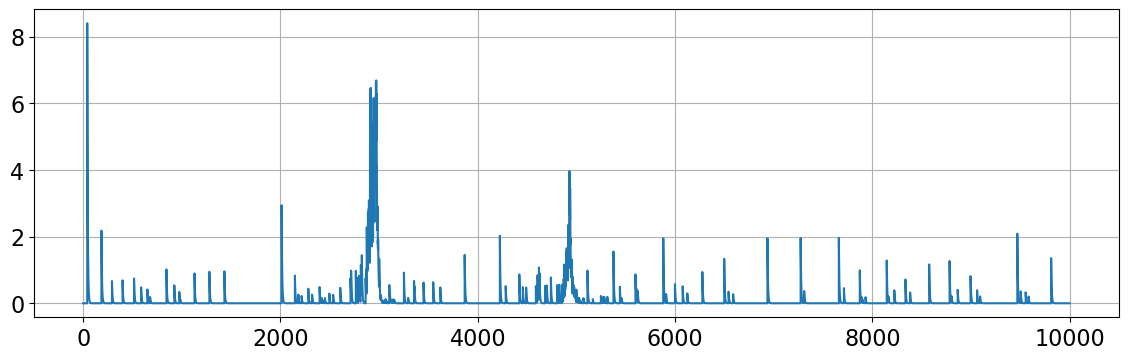

In [48]:
figure(figsize=(14,4))

plot(M.t/ms, M.g_e[k]/nS)

### Add inhibitory synapses

In [49]:
net.restore()
stdp_value = 0.1 # change between 0 and 1

In [50]:
S_input.active=True
S_exc.active=True
S_inh.active=True
G.stim_amp[:Nexc//2] = 35

In [51]:
%time net.run(10*second,report='text')

Starting simulation at t=0. s for a duration of 10. s
5.4905 s (54%) simulated in 10s, estimated 8s remaining.
10. s (100%) simulated in 18s
CPU times: user 19.1 s, sys: 5.07 ms, total: 19.1 s
Wall time: 19.1 s


Text(0, 0.5, '# Poisson generator')

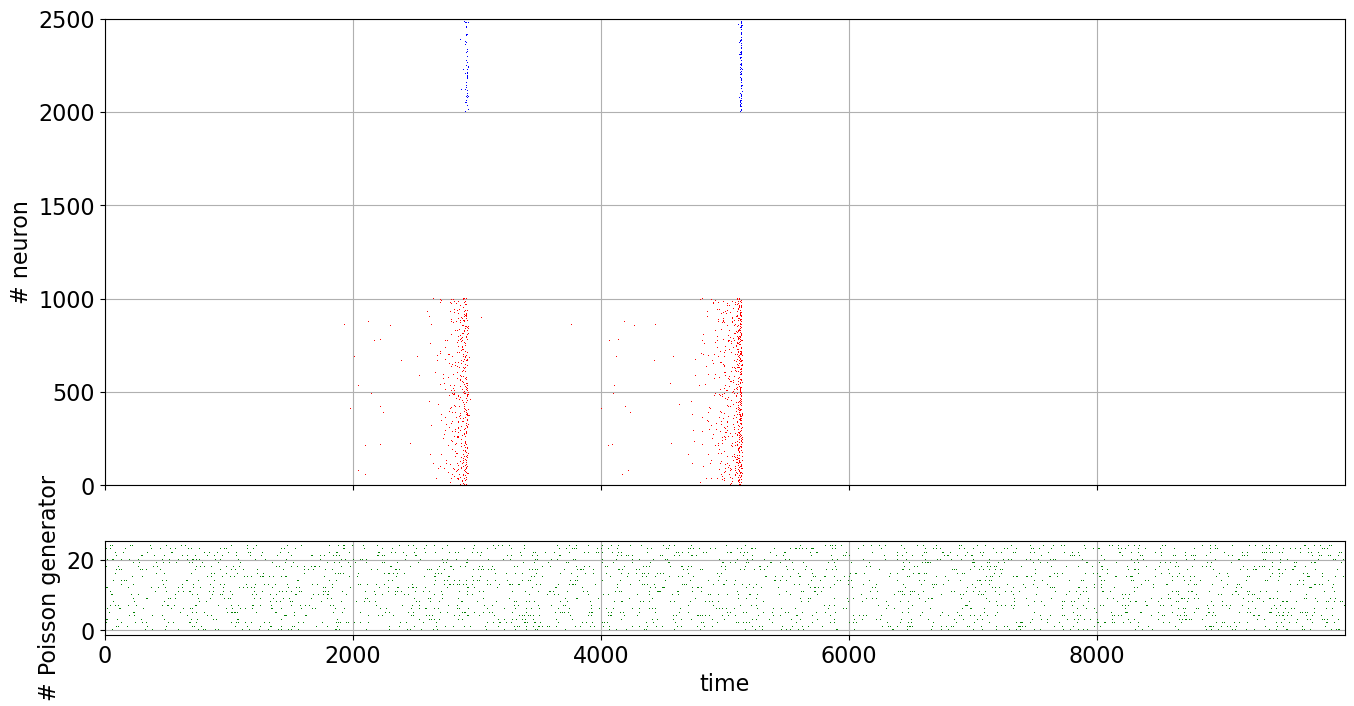

In [52]:
f,axs = subplots(2,1,sharex=True,figsize=(16,8),gridspec_kw=dict(height_ratios=(5,1)))

raster_spikes(S,Nexc,axs[0])
raster_spikes(Sp,100,axs[1],colors='gg')

axs[0].set_ylim(0,Nneurons)

xlim(M.t[0]/ms,M.t[-1]/ms)
axs[0].set_ylabel('# neuron')
xlabel('time')
ylabel('# Poisson generator')

------------------

### Optional: Selecting exemplars of interneurons and PCs by Monte-Carlo

Here we create a group of 10^4 neurons with random parameter values. Next we select only neurons with admissible behavior. 

In [53]:
start_scope()

Nneurons = 10000
#Nneurons = int(1e4)

defaultclock.dt = 0.1*ms

G = NeuronGroup(Nneurons, AdEx_equations+synaptic_equations,threshold='v>Vcut', reset='v=Vreset; w += b',
                method='exponential_euler')

G.set_states(dict(v=El,w=0))

M = StateMonitor(G, ['v','w'], record=True)
S = SpikeMonitor(G,)

In [54]:
G.a = uniform(-1,3,Nneurons)*nsiemens
G.b = uniform(5,50,Nneurons)*pA
G.tau_m = uniform(5,200,Nneurons)*ms
G.tau_w = uniform(30,100,Nneurons)*ms
G.Vreset = uniform(-60,-45,Nneurons)*mV
G.Ibias = 'randn()*5*pA'

# G.a = -0.5*nS
# G.b = 7*pA
# G.tau_m = 5*ms
# G.tau_w = 100*ms
# G.Vreset = -46*mV

In [55]:
input_current = inpf.get_step_current(1000, 2000, 1*ms, 1.0*pA,Nneurons=Nneurons)

In [56]:
store()

In [57]:
restore()
G.stim_amp = 100
%time run(5*second)

CPU times: user 19.2 s, sys: 6.77 s, total: 25.9 s
Wall time: 26 s


Text(0.5, 1.0, 'Raster plot for the neuron group during step current')

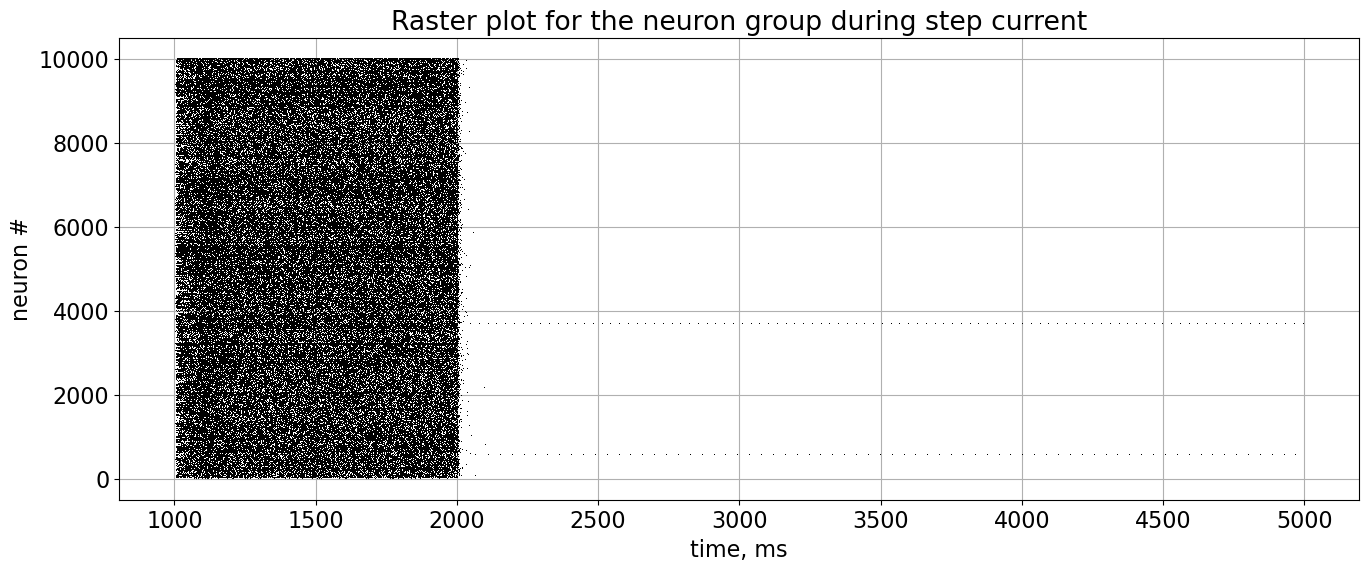

In [58]:
figure(figsize=(16,6))
plot(S.t/ms, S.i, 'k,',lw=0.5)
xlabel('time, ms')
ylabel('neuron #')
title('Raster plot for the neuron group during step current')

Text(0.5, 1.0, 'membrane voltage of a randomly chosen neuron')

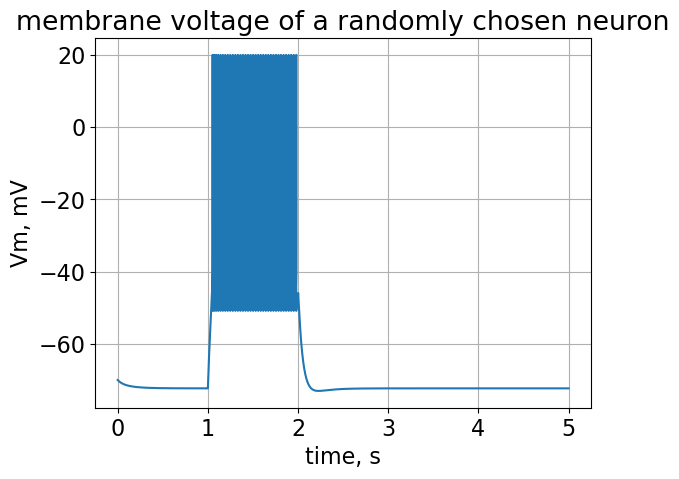

In [59]:
k = randint(Nneurons)
plot(M.t, beautify_spikes(M,S,k)/mV)
xlabel('time, s')
ylabel('Vm, mV')
title('membrane voltage of a randomly chosen neuron')

In [60]:
array([1/mean(diff((S.t[S.i==k])))])

array([36.66558827])

In [61]:
def validate_neurons(statemon,spikes,
                     min_spiking_rate = 5*Hz,
                     max_spiking_rate = 300*Hz,
                     reject_restless_prob=0.5):
    N = len(statemon.v)
    invalid = any(abs(statemon.v[:,:])>200*mV,axis=1) + isnan(statemon.v.sum(1))
    late_spikes = array([any(spikes.t[spikes.i==i]>3*second) for i in range(N)])
    
    rates = array([1/mean(diff(spikes.t[spikes.i==i]))/second if len(spikes.t[spikes.i==i])>2 else 0*Hz 
                   for i in range(N)])/second
    invalid += (rates < min_spiking_rate)
    invalid += (rates > max_spiking_rate)
    invalid += (late_spikes)&(rand(N)<reject_restless_prob)
    return ~invalid
    

In [62]:
%time valid = validate_neurons(M,S)
print(sum(valid)/Nneurons)

CPU times: user 4.22 s, sys: 1.04 s, total: 5.25 s
Wall time: 5.25 s
0.9147


In [63]:
k = where(valid)[0][randint(sum(valid))]

In [64]:
k,valid[k]

(np.int64(5023), np.True_)

Text(0, 0.5, 'Vm, mV')

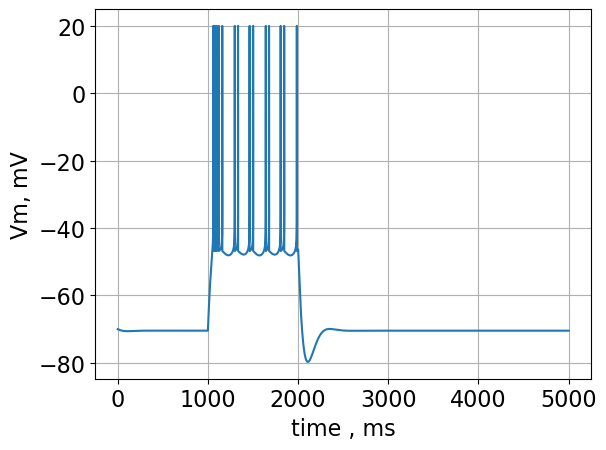

In [65]:
figure()
plot(M.t/ms,beautify_spikes(M,S,k)/mV)
xlabel('time , ms')
ylabel('Vm, mV')

In [66]:
def is_good_interneuron(statemon,spikes,k,min_rate=50*Hz,min_omega=5*Hz):
    rate = 1/mean(diff(spikes.t[spikes.i==k])) if len(spikes.t[spikes.i==k])>2 else 0*Hz
    aR = G.a[k]*Rin
    tautau = G.tau_m[k]/G.tau_w[k]
    omega = 4*(aR - 2*(1-tautau**2)/tautau)/G.tau_w[k]
    return(rate>min_rate) and (omega>0.5*min_rate)

def is_good_pyramidal(statemon,spikes,k,max_rate=25*Hz):
    rate = 1/mean(diff(spikes.t[spikes.i==k])) if len(spikes.t[spikes.i==k])>2 else 0*Hz
    aR = G.a[k]*Rin
    tautau = G.tau_m[k]/G.tau_w[k]
    omega = 4*(aR - 2*(1-tautau**2)/tautau)/G.tau_w[k]
    return(rate<=max_rate) and (omega <= 0)

In [67]:
%time interneurons = array([is_good_interneuron(M,S,k) for k in range(Nneurons)])

CPU times: user 2.57 s, sys: 108 μs, total: 2.57 s
Wall time: 2.56 s


In [68]:
%time pyramidals = array([is_good_pyramidal(M,S,k) for k in range(Nneurons)])

CPU times: user 2.71 s, sys: 58 μs, total: 2.71 s
Wall time: 2.71 s


In [69]:
acc = zeros((Nneurons,2))
for k in range(Nneurons):
    if valid[k]:
        aR = G.a[k]*Rin
        tautau = G.tau_m[k]/G.tau_w[k]
        acc[k] = tautau,aR


Text(0, 0.5, 'aR')

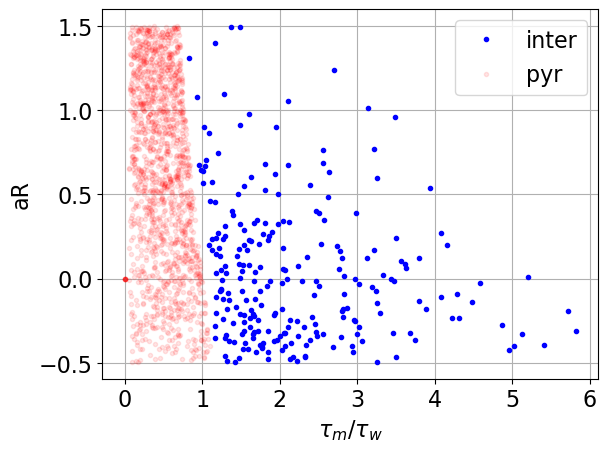

In [70]:
plot(acc[interneurons][:,0],acc[interneurons][:,1],'b.',label='inter')
plot(acc[pyramidals][:,0],acc[pyramidals][:,1],'r.',alpha=0.1, label='pyr')
legend()
xlabel('$\\tau_m/\\tau_w$')
ylabel('aR')

In [71]:
sum(interneurons)/Nneurons, sum(pyramidals)/Nneurons

(np.float64(0.0243), np.float64(0.1512))

In [72]:
interneuron_pars = dict(a=G.a[interneurons], b=G.b[interneurons],
                        tau_w=G.tau_w[interneurons],tau_m=G.tau_m[interneurons],
                        Ibias=G.Ibias[interneurons],
                        Vreset = G.Vreset[interneurons])
pyramidal_pars = dict(a=G.a[pyramidals], b=G.b[pyramidals],
                        tau_w=G.tau_w[pyramidals],tau_m=G.tau_m[pyramidals],
                        Ibias = G.Ibias[pyramidals],
                        Vreset = G.Vreset[pyramidals])

In [73]:
len(interneuron_pars['a'])

243

In [74]:
iterable(tonic_pars['a'])

False